<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/01_%EC%A0%9C%EC%8B%9C%EB%A6%AC%EB%B2%84%EB%AA%A8%EC%96%B4(%ED%98%84%EC%9E%AC_%EC%B6%94%EC%84%B8_%EB%A7%A4%EC%88%98_%EC%9D%B5%EC%A0%88_%EC%86%90%EC%A0%88%EA%B0%80)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pandas pandas_datareader numpy matplotlib

1단계: 데이터 가져오기

In [14]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# 주식 데이터 가져오기
# 심볼과 시작 날짜를 정의합니다.

symbol = '079160.KS'
start_date = '2020-01-01'

# 오늘 날짜를 end_date로 설정합니다.
end_date = datetime.now().strftime('%Y-%m-%d')

# yfinance를 사용하여 주식 데이터를 다운로드합니다.
stock_data = yf.download(symbol, start=start_date, end=end_date)

# 데이터의 마지막 몇 줄을 출력하여 확인합니다.
print(stock_data.tail())



[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close  Adj Close   Volume
Date                                                          
2024-04-02  5630.0  5830.0  5600.0  5740.0     5740.0  1100412
2024-04-03  5750.0  5850.0  5640.0  5670.0     5670.0   488131
2024-04-04  5680.0  5770.0  5670.0  5730.0     5730.0   440093
2024-04-05  5720.0  5720.0  5620.0  5640.0     5640.0   363453
2024-04-08  5640.0  5680.0  5580.0  5600.0     5600.0   336594


2단계: 기술 지표 계산하기
plt.figure(figsize=(14, 7))에서 figsize를 조정하여
차트의 크기를 변경할 수 있습니다.

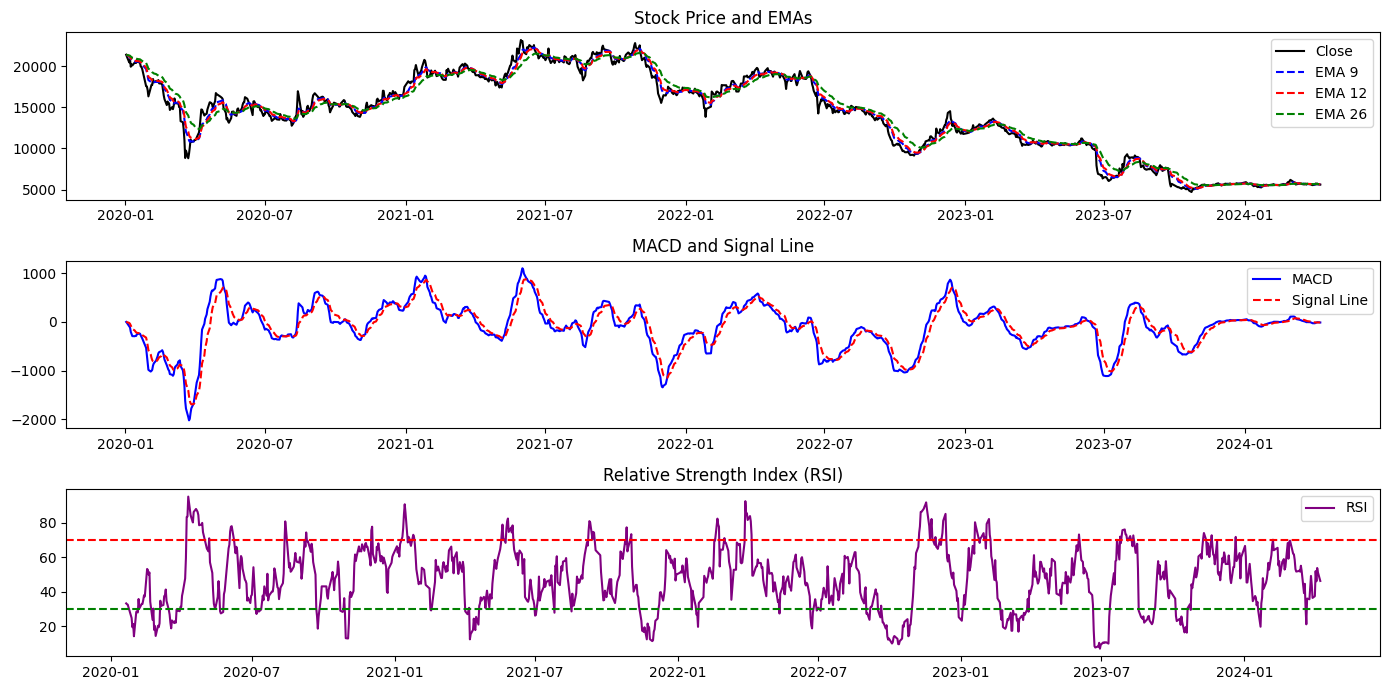

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 지수 이동 평균 (EMA) 계산
stock_data['EMA_9'] = stock_data['Close'].ewm(span=9, adjust=False).mean()
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

# MACD 계산
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

# RSI 계산
delta = stock_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + RS))

# 볼린저 밴드 계산
stock_data['Middle_BB'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Upper_BB'] = stock_data['Middle_BB'] + 2 * stock_data['Close'].rolling(window=20).std()
stock_data['Lower_BB'] = stock_data['Middle_BB'] - 2 * stock_data['Close'].rolling(window=20).std()

# 20일 평균 구매 가격 계산
stock_data['20_day_avg'] = stock_data['Close'].rolling(window=20).mean()

# 주식 종가 및 EMA 시각화
plt.figure(figsize=(14, 7))

# 종가
plt.subplot(311)  # 3행 1열의 첫 번째
plt.plot(stock_data['Close'], label='Close', color='black')
plt.plot(stock_data['EMA_9'], label='EMA 9', color='blue', linestyle='--')
plt.plot(stock_data['EMA_12'], label='EMA 12', color='red', linestyle='--')
plt.plot(stock_data['EMA_26'], label='EMA 26', color='green', linestyle='--')
plt.title('Stock Price and EMAs')
plt.legend()

# MACD 시각화
plt.subplot(312)  # 3행 1열의 두 번째
plt.plot(stock_data['MACD'], label='MACD', color='blue')
plt.plot(stock_data['Signal_Line'], label='Signal Line', color='red', linestyle='--')
plt.title('MACD and Signal Line')
plt.legend()

# RSI 시각화
plt.subplot(313)  # 3행 1열의 세 번째
plt.plot(stock_data['RSI'], label='RSI', color='purple')
plt.title('Relative Strength Index (RSI)')
plt.axhline(70, linestyle='--', color='red')  # 과매수 선
plt.axhline(30, linestyle='--', color='green')  # 과매도 선
plt.legend()

plt.tight_layout()
plt.show()



3단계: 현재 추세 분석 및 가격 범위 결정
계산된 지표를 바탕으로 현재 추세를 분석하고 주식 가격 구매 범위를 결정해 봅시다.

In [17]:
# 분석을 위한 최신 데이터 포인트
latest_data = stock_data.iloc[-1]

print(f"현재 가격: {latest_data['Close']}")
print(f"20일 평균 구매 가격: {latest_data['20_day_avg']}")

# EMA 및 MACD를 기반으로 현재 추세 판단
if latest_data['EMA_9'] > latest_data['EMA_26'] and latest_data['MACD'] > latest_data['Signal_Line']:
    print("현재 추세: 상승세")
elif latest_data['EMA_9'] < latest_data['EMA_26'] and latest_data['MACD'] < latest_data['Signal_Line']:
    print("현재 추세: 하락세")
else:
    print("현재 추세: 보합세")

# 볼린저 밴드와 평균 구매 가격을 기반으로 한 주식 가격 구매 범위 결정
print(f"구매 가격 범위: {latest_data['Lower_BB']}와 {latest_data['20_day_avg']} 사이")

# 매수가와 매도가 설정
initial_buy_price = stock_data.iloc[-1]['Close'] # 예시로 최근 종가를 초기 매수가로 설정
profit_target = 0.1 # 익절 목표 수익률 (10%)
stop_loss_target = -0.05 # 손절 목표 손실률 (-5%)
buy_increase_factor = 0.05 # 추가 매수 시 가격 상승률 (5%)

# 1차, 2차, 3차 매수가 계산
first_buy_price = initial_buy_price
second_buy_price = first_buy_price * (1 + buy_increase_factor)
third_buy_price = second_buy_price * (1 + buy_increase_factor)

# 익절가와 손절가 계산
take_profit_price = first_buy_price * (1 + profit_target)
stop_loss_price = first_buy_price * (1 + stop_loss_target)

print(f"1차 매수가: {first_buy_price}")
print(f"2차 매수가: {second_buy_price}")
print(f"3차 매수가: {third_buy_price}")
print(f"익절가: {take_profit_price}")
print(f"손절가: {stop_loss_price}")


현재 가격: 5600.0
20일 평균 구매 가격: 5655.0
현재 추세: 하락세
구매 가격 범위: 5532.654501285394와 5655.0 사이
1차 매수가: 5600.0
2차 매수가: 5880.0
3차 매수가: 6174.0
익절가: 6160.000000000001
손절가: 5320.0
